<a href="https://colab.research.google.com/github/AdeelH/tl-experiments/blob/master/semantic_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Wed Jul 10 12:50:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install rasterio

     |████████████████████████████████| 19.7MB 4.9MB/s 


In [0]:
import os
from pathlib import Path
from glob import glob
import copy

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils
import torchvision as tv
from torchvision import transforms as tf

from fastai.vision import *
from fastai.metrics import error_rate

from PIL import Image
import rasterio
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data

In [0]:
import pickle

from google.colab import drive
drive.mount('/content/gdrive')


with open('/content/gdrive/My Drive/potsdam/potsdam.pkl', 'rb') as f:
    potsdam_dict = pickle.load(f)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
identity = lambda x: x

class Potsdam(tv.datasets.VisionDataset):
    
    def __init__(self, d, chip_size=100, stride=1, tf=identity, x_tf=identity, y_tf=identity):
        super(Potsdam).__init__()

        self.data = list(d.values())
        self.fnames = list(d.keys())

        self.n = len(d)
        self.chip_size = chip_size

        im_size = self.data[0][2].shape
        self.h = ((im_size[0] - chip_size) // stride) + 1
        self.w = ((im_size[1] - chip_size) // stride) + 1

        self.tf, self.x_tf, self.y_tf = tf, x_tf, y_tf


    def __len__(self):
        return self.n * self.w * self.h
    
    def __getitem__(self, i):
        if isinstance(i, (int, np.integer)):
            return self._load(i)
        if isinstance(i, np.ndarray) or isinstance(i, torch.Tensor):
            i = i.squeeze()
            assert i.ndim in (0, 1), "too many dimensions"
            if i.ndim == 0:
                return self._load(i)
            return [self._load(j) for j in i]
        if isinstance(i, slice):
            return [self._load(j) for j in range(*i.indices(len(self.fnames)))]
        assert False, f"__getitem__(i): Invalid index"
        
    def _to_chip_idx(self, i):
        im_idx = i // (self.w * self.h)
        im_i = i % (self.w * self.h)
        chip_col = im_i % self.w
        chip_row = im_i // self.h
        return im_idx, chip_row, chip_col

    def _load(self, i):
        im_idx, chip_row, chip_col = self._to_chip_idx(i)
        rgbir, elevation, label  = self.data[im_idx]

        rgbir_chip = rgbir[:, chip_row : chip_row + self.chip_size, chip_col : chip_col + self.chip_size]
        elevation_chip = elevation[chip_row : chip_row + self.chip_size, chip_col : chip_col + self.chip_size]
        label_chip = label[chip_row : chip_row + self.chip_size, chip_col : chip_col + self.chip_size]

        x = torch.cat((rgbir_chip, elevation_chip.unsqueeze(0)), dim=0).float() / 255

        x, y = self.tf((x, label_chip))

        return self.x_tf(x), self.y_tf(y)


In [0]:
class Downsample(object):
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, arrs):
        return [np.ascontiguousarray(a[..., ::self.factor, ::self.factor]) for a in arrs]
    
    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


class RandomFlip(object):
    def __init__(self, h_prob=0.5, v_prob=0.5):
        self.h_prob = h_prob
        self.v_prob = v_prob
    
    def __call__(self, arrs):
        if torch.rand(1) < self.v_prob:
            arrs = [arr.flip(-2) for arr in arrs]
        if torch.rand(1) < self.h_prob:
            arrs = [arr.flip(-1) for arr in arrs]
        return arrs

    def __repr__(self):
        return self.__class__.__name__ + f'(h_prob={self.h_prob}, v_prob={self.v_prob})'


class ChannelSelect(object):
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, arr):
        return arr[self.channels]

    def __repr__(self):
        return self.__class__.__name__ + f'(channels={self.channels})'
    


In [0]:
channels = [4]

train_transform = tf.Compose([
    Downsample(2),
    tf.Lambda(lambda xs: [torch.tensor(x) for x in xs]),
    RandomFlip(),
])

val_transform = tf.Compose([
    Downsample(2),
    tf.Lambda(lambda xs: [torch.tensor(x) for x in xs]),
])

x_transform = tf.Compose([
    ChannelSelect(channels)
])

y_transform = tf.Compose([
    tf.Lambda(lambda x: x.long())
])


In [0]:
train_ds = Potsdam(potsdam_dict, chip_size=400, stride=200, tf=train_transform, x_tf=x_transform, y_tf=y_transform)
val_ds = Potsdam(potsdam_dict, chip_size=400, stride=200, tf=val_transform, x_tf=x_transform, y_tf=y_transform)

In [0]:
len(val_ds)

15138

In [0]:
val_ds[0][0].shape

torch.Size([1, 200, 200])

# Split into train and validation sets using `SubsetRandomSampler()`

In [0]:
train_split_size = int(len(train_ds) * .85 // 1)
val_split_size = len(train_ds) - train_split_size
train_split_size, val_split_size

print('train_split_size', train_split_size)
print('val_split_size', val_split_size)

inds = np.arange(len(train_ds))
np.random.shuffle(inds)

train_split_size 12867
val_split_size 2271


In [0]:
train_sampler = torch.utils.data.SubsetRandomSampler(inds[:train_split_size])
val_sampler = torch.utils.data.SubsetRandomSampler(inds[train_split_size:])

# Model

In [0]:
def _base_model(pretrained=False):
    m = tv.models.resnet18(pretrained=pretrained)
    m._modules['conv1'] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return m


In [0]:
model = models.unet.DynamicUnet(create_body(_base_model, pretrained=True), 6).cuda()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 73359944.83it/s]


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [0]:
val_iter = (iter(val_sampler))

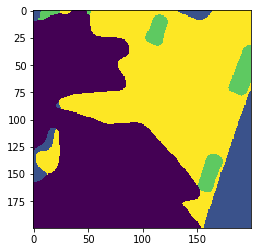

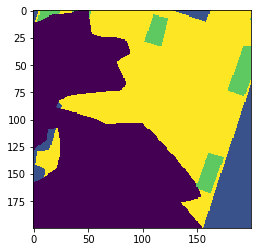

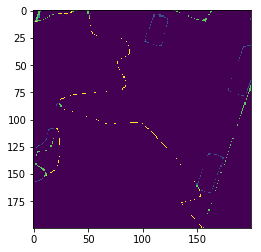

In [31]:
i = next(val_iter)

model.eval()
with torch.no_grad():
    x = val_ds[i][0][-1:].unsqueeze(0).cuda()
    out = model(x)
    
yhat = out.cpu().squeeze().permute(1, 2, 0).argmax(dim=-1)

plt.imshow(yhat)
plt.show()

plt.imshow(val_ds[i][1])
plt.show()

plt.imshow((val_ds[i][1] - yhat).abs())
plt.show()



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

def save_model(model, name, info={}):
    state = {
        'model': model.state_dict(),
        'info': info
    }
    path = F"/content/gdrive/My Drive/potsdam/models/{name}" 
    torch.save(state, path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import time

    
def validate(model, criterion, val_dl):
    
    loss = 0.
    corrects = 0
    count = 0
    
    torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        for i, (batch, labels) in enumerate(val_dl):
            N = batch.shape[0]
            batch = batch.cuda()
            labels = labels.view(-1)

            preds = model(batch).detach().cpu().permute(0, 2, 3, 1).contiguous()
            preds = preds.view(-1, preds.shape[-1])
            
            loss += criterion(preds, labels)
            corrects += (preds.argmax(dim=-1) == labels).detach().float().sum()
            count += len(labels)

    acc = corrects.float() / count
#     loss /=  count
    return loss, acc


def train_epoch(model, train_dl, criterion, optimizer):
    
    loss = 0.
    corrects = 0
    count = 0

    model.train()
    for i, (batch, labels) in enumerate(train_dl):
        N = batch.shape[0]
        batch = batch.cuda()
        labels = labels.view(-1).cuda()

        preds = model(batch).permute(0, 2, 3, 1).contiguous()
        preds = preds.view(-1, preds.shape[-1])
        
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.detach().cpu()
        corrects += (preds.argmax(dim=-1) == labels).detach().cpu().sum()
        count += len(labels)

    acc = corrects.float() / count
#     loss /=  count
    
    return loss, acc


def train_seg(model, train_dl, val_dl, optimizer, sched, params, criterion=nn.CrossEntropyLoss(), callback=lambda x: None, save_name='model', best_acc=0.85):
    '''Train a classification model.
    
    Args:
        - model: The model to be trained (must be a `nn.Module`).
        - train_dl: A `torch.utils.data.Dataloader` for training data.
        - val_dl: A `torch.utils.data.Dataloader` for validation data.
        - optimizer: The optimizer to use for training.
        - sched: The LR scheduler to use for training. `sched.step()` will be called after each epoch.
        - params: Additional training parameters.
        - criterion: Loss function.
        - callback: A callback that is called at the end of each epoch.
        - save_name: Filename to use for saving the model.
        - best_acc: Initial value for best-accuracy-so-far.
    '''

    torch.cuda.empty_cache()
    for epoch in range(params['epochs']):
        
        start_time = time.time()

        # train (fwd pass and backprop)
        epoch_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer)

        # validate
        val_loss, val_acc = validate(model, criterion, val_dl)

        # save best model so far
        # save only if there is an improvement of >=0.05%
        if val_acc >= (best_acc + 0.005):
            best_acc = val_acc
            info = {'acc': val_acc, 'epoch': epoch, 'val_loss': val_loss, 'lr': optimizer.param_groups[0]['lr']}
            save_model(model, save_name, info=info)

        print('epoch: %3d, lr: %0.8f, epoch_loss: %4.4f, val_loss: %4.4f, train_acc: %0.4f, val_acc: %0.4f, best: %0.4f, time: %0.1f' % \
              (epoch, optimizer.param_groups[0]['lr'], epoch_loss, val_loss, train_acc, val_acc, best_acc, time.time() - start_time))
        sched.step()
        callback(model)


In [0]:
train_params = {}
train_params['batch_size'] = 32
train_params['val_batch_size'] = 64

In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, sampler=train_sampler, batch_size=train_params['batch_size'], pin_memory=False, num_workers=4)
val_dl = torch.utils.data.DataLoader(val_ds, sampler=val_sampler, batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [0]:

train_params = {}
train_params['epochs'] = 5
train_params['learning_rate'] = 1e-2
train_params['learning_rate_min'] = 1e-3

train_params['model_save_name'] = 'resnet18_elevation_100x100_7x7'

optimizer = optim.SGD(model.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate_min'])

train_seg(model, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'], best_acc=0.975)


epoch:   0, lr: 0.01000000, epoch_loss: 1.1804, val_loss: 1.2310, train_acc: 0.9862, val_acc: 0.9870, best: 0.9870, time: 439.0
epoch:   1, lr: 0.00914058, epoch_loss: 2.3181, val_loss: 1.1683, train_acc: 0.9855, val_acc: 0.9877, best: 0.9870, time: 424.8
epoch:   2, lr: 0.00689058, epoch_loss: 0.1303, val_loss: 1.0699, train_acc: 0.9867, val_acc: 0.9890, best: 0.9870, time: 424.8
epoch:   3, lr: 0.00410942, epoch_loss: 1.0722, val_loss: 1.0209, train_acc: 0.9881, val_acc: 0.9896, best: 0.9870, time: 424.6
epoch:   4, lr: 0.00185942, epoch_loss: 0.2592, val_loss: 0.9958, train_acc: 0.9885, val_acc: 0.9897, best: 0.9870, time: 425.0


In [0]:
validate(model, nn.CrossEntropyLoss(), val_dl)

(tensor(32.7899), tensor(0.2416))

In [0]:
def load_weights(model_save_name, model):
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    path = F"/content/gdrive/My Drive/potsdam/models/{model_save_name}"
    state = torch.load(path)
    print(state['info'])
    model.load_state_dict(state['model'])

load_weights('resnet18_elevation_100x100_7x7', model)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'acc': tensor(0.9871), 'epoch': 0, 'val_loss': tensor(1.2504), 'lr': 0.01}


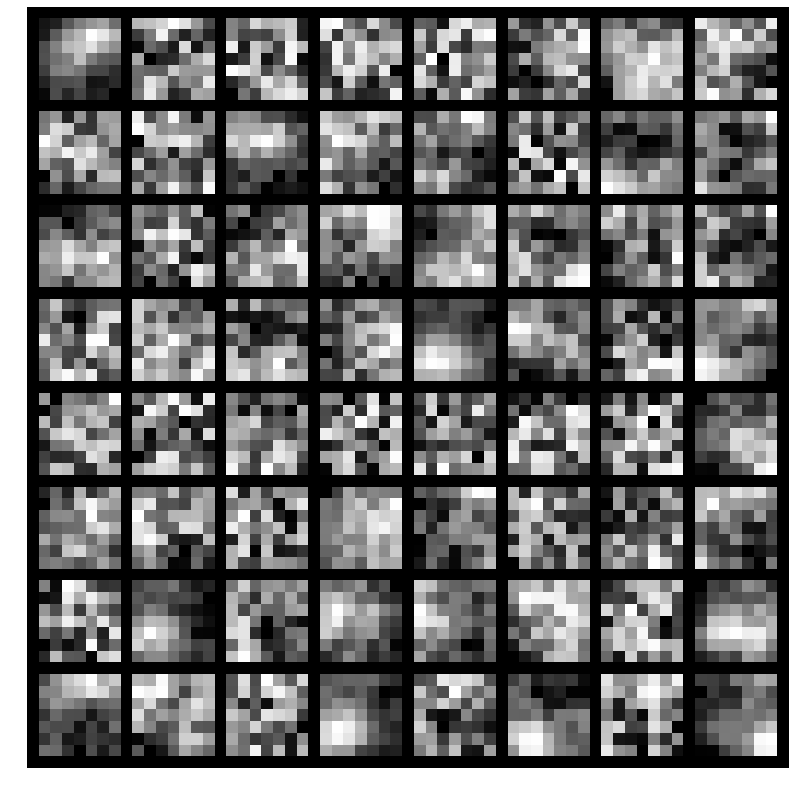

In [22]:
def viz_filters(conv_layer, scale_each=True):
    fs = conv_layer.weight.data.clone().detach().cpu()
    grid = tv.utils.make_grid(fs, normalize=True, scale_each=scale_each, padding=1).permute(1, 2, 0)

    plt.figure(figsize=(14, 14))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()
    
viz_filters(model[0][0], scale_each=True)

In [0]:
model